In [13]:
# Import Information
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
# Load the dataset
train = pd.read_csv('/Users/jamespecore/Documents/Github/data_science/Projects/store_item_demand_forecasting/data/train.csv')
test = pd.read_csv('/Users/jamespecore/Documents/Github/data_science/Projects/store_item_demand_forecasting/data/test.csv')

In [15]:
def preprocess_data(data):
    # Convert the 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])
    return data

# Apply preprocessing to train and test data
train = preprocess_data(train)
test = preprocess_data(test)

In [16]:
def format_datetime(data):
    # Extract additional date-related features
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['day_of_week'] = data['date'].dt.dayofweek
    return data

train = format_datetime(train)
test = format_datetime(test)

print(train)

             date  store  item  sales  year  month  day  day_of_week
0      2013-01-01      1     1     13  2013      1    1            1
1      2013-01-02      1     1     11  2013      1    2            2
2      2013-01-03      1     1     14  2013      1    3            3
3      2013-01-04      1     1     13  2013      1    4            4
4      2013-01-05      1     1     10  2013      1    5            5
...           ...    ...   ...    ...   ...    ...  ...          ...
912995 2017-12-27     10    50     63  2017     12   27            2
912996 2017-12-28     10    50     59  2017     12   28            3
912997 2017-12-29     10    50     74  2017     12   29            4
912998 2017-12-30     10    50     62  2017     12   30            5
912999 2017-12-31     10    50     82  2017     12   31            6

[913000 rows x 8 columns]


In [17]:
# Exploratory Data Analysis
train.describe()

,date,store,item,sales,year,month,day,day_of_week
count,913000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287,2015.000548,6.523549,15.727820,3.001643
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000,2013.000000,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000,2014.000000,4.000000,8.000000,1.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000,2015.000000,7.000000,16.000000,3.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000,2016.000000,10.000000,23.000000,5.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000,2017.000000,12.000000,31.000000,6.000000
std,NaN,2.872283,14.430878,28.801144,1.414021,3.448535,8.799329,1.999316


In [18]:
# Min and Max Date Retrieval Functions
def min_date(data):
    return data['date'].min().date()

def max_date(data):
    return data['date'].max().date()

In [19]:
# MiniMax Date from Train Set
print('Min date from train set:', min_date(train))
print('Max date from train set:', max_date(train))

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [20]:
# MiniMax Date from Test Set
print('Min date from test set:', min_date(test))
print('Max date from test set:', max_date(test))

Min date from test set: 2018-01-01
Max date from test set: 2018-03-31


In [21]:
# Calculate the forecast lag size, which represents the number of days between the last date in the train set
# and the last date in the test set
lag_size = (test['date'].max().date() - train['date'].max().date()).days

# Print the results
print('Last date in the train set: %s' % train['date'].max().date())
print('Last date in the test set: %s' % test['date'].max().date())
print('Forecast lag size (days between train and test set):', lag_size)

Last date in the train set: 2017-12-31
Last date in the test set: 2018-03-31
Forecast lag size (days between train and test set): 90


In [22]:
# Aggregate daily sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()

# Aggregate daily sales per store
store_daily_sales = train.groupby(['store', 'date'])['sales'].sum().reset_index()

# Aggregate daily sales per item
item_daily_sales = train.groupby(['item', 'date'])['sales'].sum().reset_index()

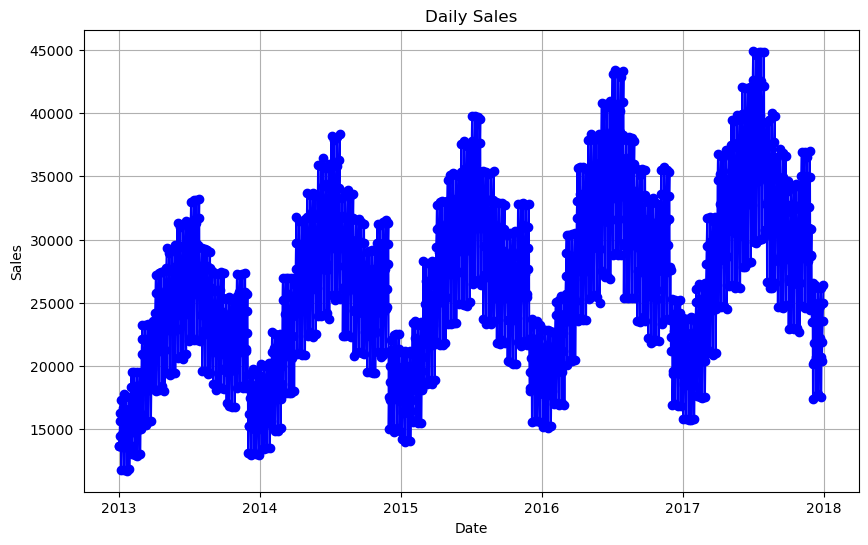

In [23]:
# Plot daily sales using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], marker='o', linestyle='-', color='b')
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [35]:
# Step 1: Rearrange Dataset
def rearrange_dataset(data):
    # Group by item, store, and date, calculate mean sales
    data_grouped = data.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
    data_grouped = data_grouped.agg({'sales': 'mean'})
    data_grouped.columns = ['item', 'store', 'date', 'sales']
    return data_grouped

In [36]:
# Step 2: Transform Data into a Time Series Problem
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [37]:
# Step 3: Remove Rows with Different Item or Store Values
def filter_inconsistent_data(data):
    last_item = 'item(t-%d)' % window
    last_store = 'store(t-%d)' % window
    data_filtered = data[(data['store(t)'] == data[last_store])]
    data_filtered.reset_index(drop=True, inplace=True)
    
    # Reset indices of the original data DataFrame
    data.reset_index(drop=True, inplace=True)
    
    return data_filtered

In [38]:
# Step 4: Remove Unwanted Columns
def drop_unwanted_columns(data, window, lag):
    columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
    for i in range(window, 0, -1):
        columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
    data.drop(columns_to_drop, axis=1, inplace=True)
    data.drop(['item(t)', 'store(t)'], axis=1, inplace=True)
    return data

In [39]:
# Step 5: Train/Validation Split
def split_train_valid(data, labels_col, test_size=0.4, random_state=0):
    labels = data[labels_col]
    data = data.drop(labels_col, axis=1)
    X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels.values, test_size=test_size, random_state=random_state)
    print('Train set shape:', X_train.shape)
    print('Validation set shape:', X_valid.shape)
    return X_train, X_valid, Y_train, Y_valid


In [40]:
# Apply preprocessing steps
train_gp = rearrange_dataset(train)
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series = filter_inconsistent_data(series)
series = drop_unwanted_columns(series, window, lag)
X_train, X_valid, Y_train, Y_valid = split_train_valid(series, 'sales(t+%d)' % lag_size)

Train set shape: (539046, 30)
Validation set shape: (359364, 30)


In [48]:
# Check the shape of the input data
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

# Reshape input data for LSTM model (add a third dimension for the single channel)
X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid_lstm = X_valid.values.reshape(X_valid.shape[0], X_valid.shape[1], 1)


X_train shape: (539046, 30)
X_valid shape: (359364, 30)


In [50]:
# Build LSTM model architecture
lstm_model = Sequential([
    LSTM(10, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])

# Compile LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM model
history = lstm_model.fit(X_train_lstm, Y_train, epochs=10, batch_size=32, validation_data=(X_valid_lstm, Y_valid), verbose=1)

Epoch 1/10
16846/16846 ━━━━━━━━━━━━━━━━━━━━ 103s 6ms/step - loss: 692.9466 - val_loss: 324.2439
Epoch 2/10
16846/16846 ━━━━━━━━━━━━━━━━━━━━ 106s 6ms/step - loss: 360.1615 - val_loss: 310.6847
Epoch 3/10
16846/16846 ━━━━━━━━━━━━━━━━━━━━ 104s 6ms/step - loss: 368.1906 - val_loss: 456.4842
Epoch 4/10
16838/16846 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 387.3663

## **Conclusion**

In this exploration of time series problem-solving approaches, we've delved into various methods and their distinctions. While the focus here wasn't on achieving peak performance, you're encouraged to experiment with different hyperparameters, particularly the window size and network topology, to enhance results. If you do, please share your findings with me.

I hope this journey has imparted valuable insights. Your feedback is invaluable, so feel free to share your thoughts. If you enjoyed this content, consider exploring this reference dataset to try this out yourself. 